In [1]:
from astropy.timeseries import LombScargle

np.random.seed(1)

In [2]:
path = '/Users/mbedell/python/thethethe/cadence/'
t_zenith = np.genfromtxt(path+'t_zeniths.txt', skip_header=1)
t_randomized = np.genfromtxt(path+'t_randomized.txt', skip_header=1)
t_super_random = np.genfromtxt(path+'t_super_random.txt', skip_header=1)
t_zenith_strict = np.genfromtxt(path+'t_zeniths_strict.txt', skip_header=1)

In [3]:
# patch up ends of observing seasons where randomizing failed
bad_inds = np.arange(len(t_randomized))[~np.isfinite(t_randomized)]
for i in bad_inds:
    t_randomized[i] = t_zenith[i]
print(bad_inds)

[1534 2300]


### generate an orbit

In [4]:
import radvel

/Users/mbedell/python/radvel/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [5]:
param = radvel.model.Parameters(1, basis='per tp e w k')
param['per1'].value = 290. #days
param['tp1'].value = 100.
param['e1'].value = 0.1 
param['w1'].value = np.pi
param['k1'].value = 0.09 # m/s

In [6]:
param.values()

--
PLANET 1:
per: 290.0
tp: 100.0
e: 0.1
w: 3.141592653589793
k: 0.09


In [7]:
def inject_all(param, ts_all):
    model = radvel.model.RVModel(param)
    N = len(ts_all)
    ys_all = []
    for i in range(N):
        ys_all.append(model(ts_all[i], use_c_kepler_solver=False))
    return ys_all

In [8]:
ts_all = [t_zenith, t_zenith_strict, t_randomized, t_super_random]
ys_all = inject_all(param, ts_all)

### simulate noise

In [9]:
def white_noise_all(ts_all, ys_all, noise_amp=0.3):
    yerrs_all = []
    for i in range(len(ts_all)):
        ys_all[i] += np.random.normal(0., noise_amp, len(ts_all[i]))
        yerrs_all.append(np.zeros_like(ys_all[i]) + noise_amp)
    return ys_all, yerrs_all

In [10]:
ys_all, yerrs_all = white_noise_all(ts_all, ys_all, noise_amp=0.3) # amp is in m/s
ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random = ys_all
yerrs_zenith, yerrs_zenith_strict, yerrs_randomized, yerrs_super_random = yerrs_all

### simulate detection with periodogram

In [11]:
# copied from notebook 02

def plot_periodograms(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random, 
                     mark_periods=[]):
    frequency, power_zenith = LombScargle(t_zenith, 
                                      ys_zenith, dy=yerrs_zenith).autopower(minimum_frequency=0.001,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=10)
    power_randomized = LombScargle(t_randomized, 
                               ys_randomized, dy=yerrs_randomized).power(frequency)
    power_zenith_strict = LombScargle(t_zenith_strict, 
                               ys_zenith_strict, dy=yerrs_zenith_strict).power(frequency)
    power_super_random = LombScargle(t_super_random, 
                               ys_super_random, dy=yerrs_super_random).power(frequency)
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
    ax1.plot(1./frequency, power_zenith, alpha=0.6, label='zenith times')
    ax1.plot(1./frequency, power_zenith_strict, alpha=0.6, label='strict zenith times')
    ax2.plot(1./frequency, power_randomized, alpha=0.6, label='randomized times', color='C2')
    ax2.plot(1./frequency, power_super_random, alpha=0.6, label='super-randomized times', color='C4')
    ax2.set_xlabel('Period (days)', fontsize=14)
    for ax in (ax1, ax2):
        ax.set_ylabel('Power', fontsize=14)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        for mp in mark_periods:
            ax.axvline(mp, c='k', ls='--', alpha=0.6)
    return fig, (ax1,ax2)

def plot_timeseries(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random):
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
    ax1.errorbar(t_zenith, ys_zenith, yerrs_zenith, ls='', 
                fmt='o', alpha=0.7, label='zenith times')
    ax1.errorbar(t_zenith_strict, ys_zenith_strict, yerrs_zenith_strict, ls='', 
                fmt='o', alpha=0.7, label='strict zenith times')
    ax2.errorbar(t_randomized, ys_randomized, yerrs_randomized, ls='', 
                fmt='o', alpha=0.7, label='randomized times', color='C2')
    ax2.errorbar(t_super_random, ys_super_random, yerrs_super_random, ls='', 
                fmt='o', alpha=0.7, label='super-randomized times', color='C4')
    ax2.set_xlabel('Time (days)', fontsize=14)
    for ax in (ax1, ax2):
        ax.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
        ax.legend();
    return fig, (ax1,ax2)

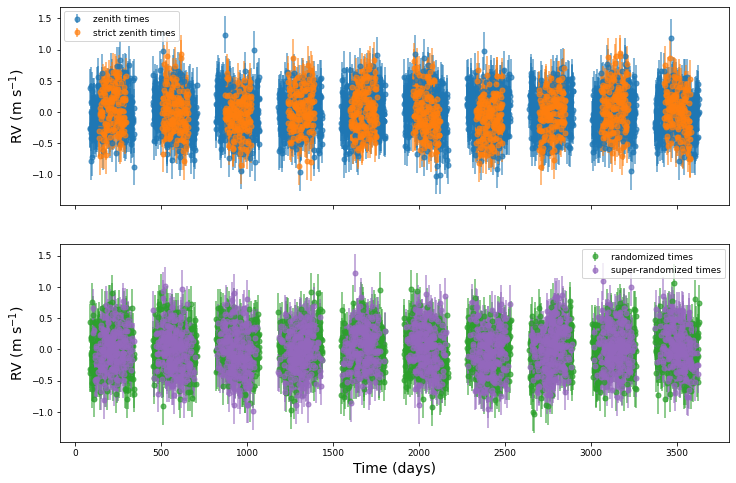

In [12]:
plot_timeseries(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random);

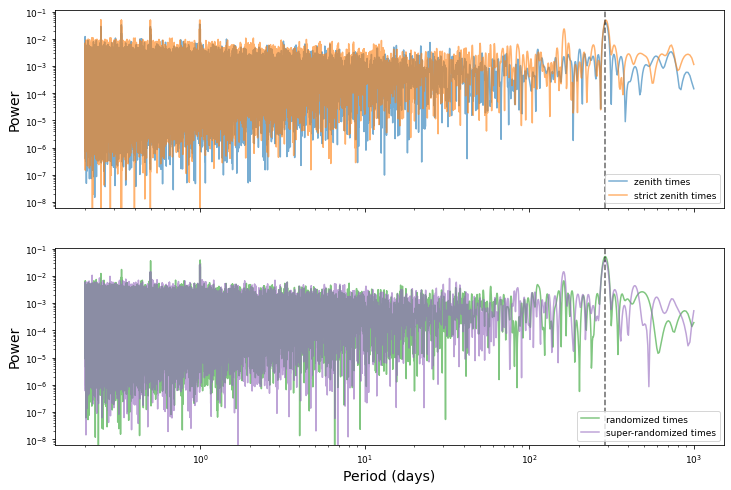

In [13]:
plot_periodograms(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random,
                  mark_periods = [param['per1'].value]);

### check out the likelihood function behavior near true orbit

In [14]:
def plot_chisq_onepar(param, par_name, ts, ys, yerrs, scale=0.1, ax=None):
    true_value = np.copy(param[par_name].value)
    vals = np.linspace(-1, 1, 100) * true_value * scale + true_value
    chisqs = []
    for val in vals:
        param[par_name].value = val
        model = radvel.model.RVModel(param)
        chisqs.append(np.sum((ys - model(ts))**2/yerrs**2))
    chisqs = np.array(chisqs)
    param[par_name].value = true_value
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.plot(vals, np.array(chisqs))
    ax.axvline(true_value, c='k', ls='--')
    ax.set_xlabel(par_name, fontsize=14)
    ax.set_ylabel(r'$\chi^2$', fontsize=14);

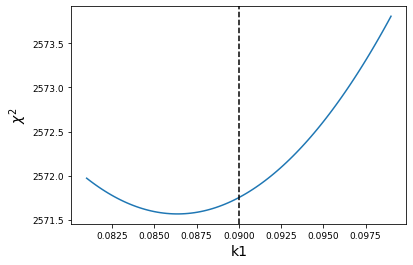

In [15]:
par_name = 'k1'
ts, ys, yerrs = t_zenith, ys_zenith, yerrs_zenith
plot_chisq_onepar(param, par_name, ts, ys, yerrs, scale=0.1)

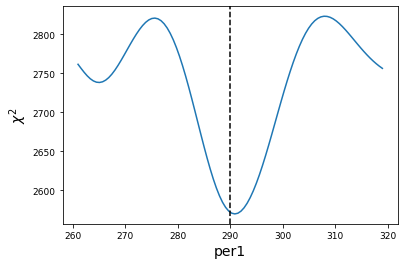

In [16]:
par_name = 'per1'
ts, ys, yerrs = t_zenith, ys_zenith, yerrs_zenith
plot_chisq_onepar(param, par_name, ts, ys, yerrs, scale=0.1)

In [17]:
def plot_chisq_onepar_all(param, par_name, ts_all, ys_all, yerrs_all, 
                          labels_all, colors_all, scale=0.1, ax=None):
    true_value = np.copy(param[par_name].value)
    vals = np.linspace(-1, 1, 100) * true_value * scale + true_value
    N = len(ts_all)
    chisqs_all = [[] for i in range(N)]
    for val in vals:
        param[par_name].value = val
        model = radvel.model.RVModel(param)
        for i in range(N):
            chisqs_all[i].append(np.sum((ys_all[i] - model(ts_all[i]))**2/yerrs_all[i]**2))
    param[par_name].value = true_value
    if ax is None:
        fig,ax = plt.subplots(1,1)
    for i in range(N):
        chisqs = np.asarray(chisqs_all[i])
        ax.plot(vals, chisqs/np.min(chisqs), label=labels_all[i], c=colors_all[i])
    ax.axvline(true_value, c='k', ls='--')
    ax.set_xlabel(par_name, fontsize=14)
    ax.set_ylabel(r'$\chi^2$/min($\chi^2$)', fontsize=14)
    ax.legend();

In [18]:
labels_all = ['zenith times', 'strict zenith times', 'randomized times', 'super-randomized times']
colors_all = ['C0', 'C1', 'C2', 'C4']

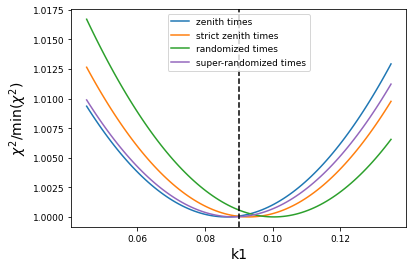

In [19]:
plot_chisq_onepar_all(param, 'k1', ts_all, ys_all, yerrs_all, labels_all, colors_all,
                      scale=0.5)

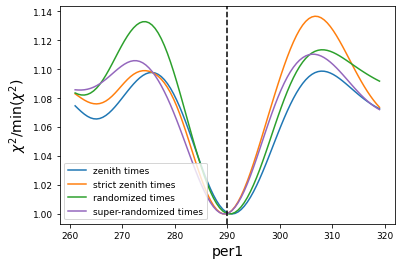

In [20]:
plot_chisq_onepar_all(param, 'per1', ts_all, ys_all, yerrs_all, labels_all, colors_all,
                      scale=0.1)

### randomize the phase

In [21]:
param = radvel.model.Parameters(1, basis='per tp e w k')
param['per1'].value = 290. #days
param['tp1'].value = 100.
param['e1'].value = 0.1 
param['w1'].value = np.random.random() * 2. * np.pi
param['k1'].value = 0.09 # m/s

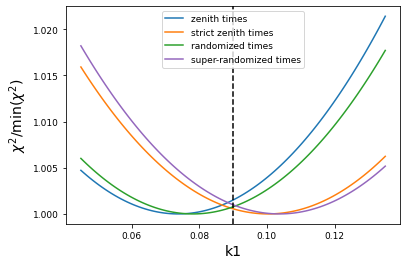

In [22]:
ys_all = inject_all(param, ts_all)
ys_all, yerrs_all = white_noise_all(ts_all, ys_all, noise_amp=0.3) # amp is in m/s
plot_chisq_onepar_all(param, 'k1', ts_all, ys_all, yerrs_all, labels_all, colors_all,
                      scale=0.5)